<a href="https://www.kaggle.com/code/kevinnkansah/maize-classification-vgg16-cnn-transfer-learning?scriptVersionId=184277473" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten,
)
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings("ignore")

strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

2024-06-19 00:06:37.356524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 00:06:37.356660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 00:06:37.515740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of devices: 2


#### Context

Maize classification has been achieved through the utilization of deep learning techniques with hyperspectral imaging. However, the high-power consumption of GPUs frequently prevents the deployment of these automated methods on embedded devices, necessitating the allocation of significant processing and computing resources. Access to local maize data in Ghana to perform classification tasks is also exceedingly challenging. To overcome these obstacles, the objective of this research is to generate a straightforward dataset that includes three distinct varieties of local maize seeds in Ghana: Wang Dataa, Sanzal Sima, and Bihilifa. The objective is to expedite the creation of a maize classification tool that is both efficient and cost-effective while simultaneously minimizing human involvement in the seed grading process for marketing and production.
The dataset is organized into a single folder named MaizeData, which contains a total of 17,724 entries. Three subfolders from each of the three varieties (classes) are included in the MaizeData folder. In particular, the Bhihilifa class contains 6,480 files, the Sanzal Sima class contains 5,100 files, and the Wang Dataa class contains 6,144 images. All of the images have undergone validation by experts from Heritage Seeds Ghana and are open for use by researchers.

In [2]:
BHIHILIFA = "/kaggle/input/maize-seed-dataset/MaizeData/Bhihilifa"
SANZALSIMA = "/kaggle/input/maize-seed-dataset/MaizeData/SanzalSima"
WANGDATAA = "/kaggle/input/maize-seed-dataset/MaizeData/WangDataa"

file_paths = (
    [os.path.join(BHIHILIFA, f) for f in os.listdir(BHIHILIFA)]
    + [os.path.join(SANZALSIMA, f) for f in os.listdir(SANZALSIMA)]
    + [os.path.join(WANGDATAA, f) for f in os.listdir(WANGDATAA)]
)
labels = (
    ["Bhihilifa"] * len(os.listdir(BHIHILIFA))
    + ["Sanzal Sima"] * len(os.listdir(SANZALSIMA))
    + ["Wang Dataa"] * len(os.listdir(WANGDATAA))
)

data = {"file_paths": file_paths, "labels": labels}
df = pd.DataFrame.from_dict(data)
del data
df.head()

,file_paths,labels
0,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
1,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
2,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
3,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
4,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa


## Data Visualization

In [3]:
px.pie(df, names="labels", title="Distribution of labels")

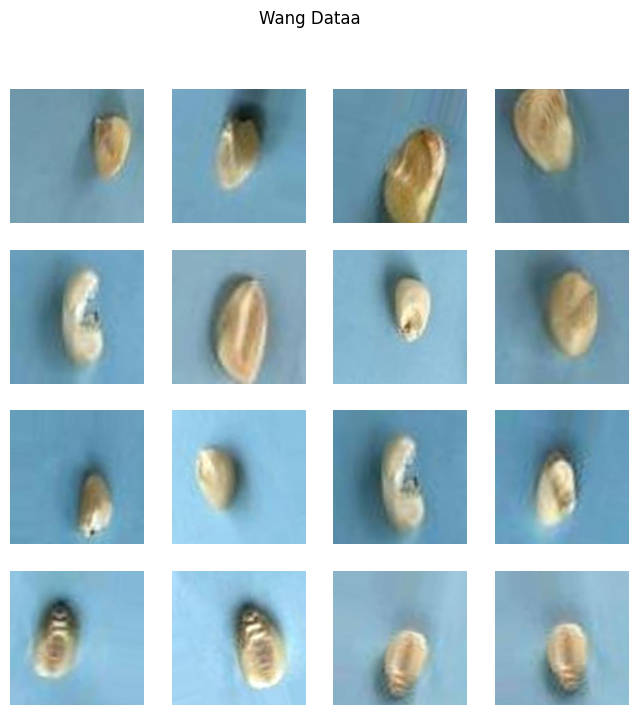

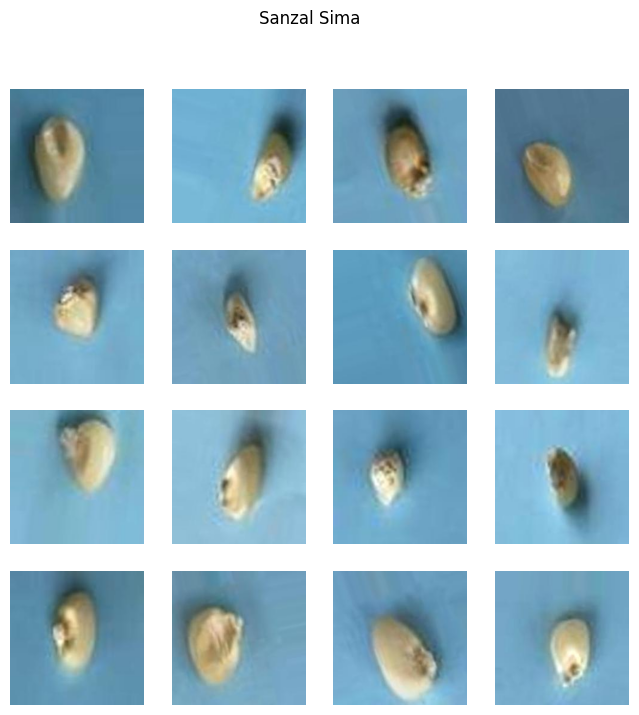

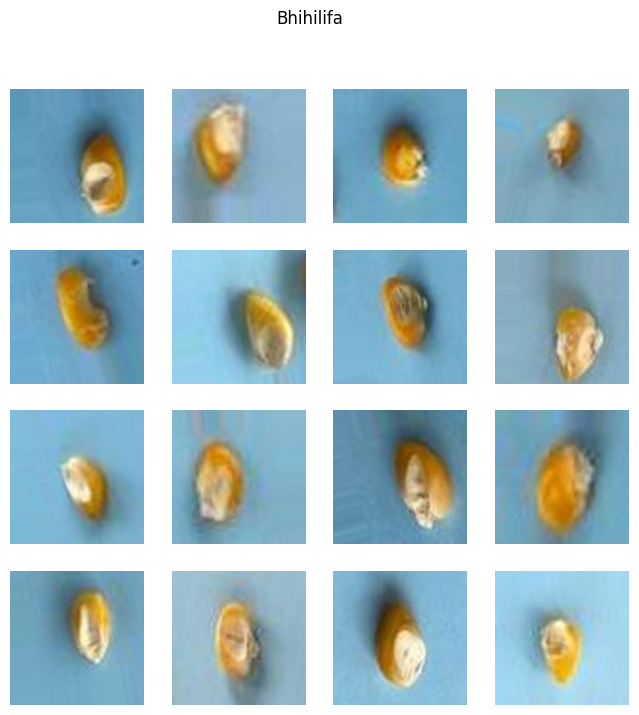

In [4]:
def plot_imgs(label):
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    axs = axs.flatten()
    df_label = df[df["labels"] == label]
    plt.suptitle(label)
    for idx, img in enumerate(df_label["file_paths"][:16]):
        image = imread(img)
        ax = axs[idx]
        ax.imshow(image)
        ax.axis("off")


plot_imgs("Wang Dataa")
plot_imgs("Sanzal Sima")
plot_imgs("Bhihilifa")

## Data Preprocessing

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head(20)

,file_paths,labels
0,/kaggle/input/maize-seed-dataset/MaizeData/San...,Sanzal Sima
1,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
2,/kaggle/input/maize-seed-dataset/MaizeData/Wan...,Wang Dataa
3,/kaggle/input/maize-seed-dataset/MaizeData/San...,Sanzal Sima
4,/kaggle/input/maize-seed-dataset/MaizeData/Bhi...,Bhihilifa
5,/kaggle/input/maize-seed-dataset/MaizeData/San...,Sanzal Sima
6,/kaggle/input/maize-seed-dataset/MaizeData/San...,Sanzal Sima
7,/kaggle/input/maize-seed-dataset/MaizeData/Wan...,Wang Dataa
8,/kaggle/input/maize-seed-dataset/MaizeData/Wan...,Wang Dataa
9,/kaggle/input/maize-seed-dataset/MaizeData/Wan...,Wang Dataa


To stratify the data means to have the labels (what we are statifying by) in equal preportiions as seen in the pie chart above.

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'],  random_state=42)

In [8]:
print(train_df.shape, val_df.shape, test_df.shape)

(12406, 2) (2659, 2) (2659, 2)


In [9]:
train_datagen = ImageDataGenerator(rescale=1./ 255)
val_datagen = ImageDataGenerator(rescale=1./ 255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(224, 224),
    shuffle=True,
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(224, 224),
    shuffle=False,
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_paths",
    y_col="labels",
    target_size=(224, 224),
    shuffle=False,
)

Found 12406 validated image filenames belonging to 3 classes.
Found 2659 validated image filenames belonging to 3 classes.
Found 2659 validated image filenames belonging to 3 classes.


## Model Training (Transfer Learning using VGG16)

*If you fork this I adivise you use do not use GPU P100 as I got strange cuDNN log errors whilst using it*

In [11]:
with strategy.scope(): # for using both GPUs
    pretrained_model = VGG16(include_top=False,
                             weights="imagenet",
                             input_shape=(224, 224, 3))


    pretrained_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = pretrained_model(inputs, training=False)

    x = Conv2D(128, (3, 3), activation='swish', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='swish', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(512, (3, 3), activation='swish', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (3, 3), activation='swish', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='swish')(x)
    x = BatchNormalization()(x)

    outputs = Dense(3, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="nadam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,511,491 (89.69 MB)

 Trainable params: 8,791,427 (33.54 MB)

 Non-trainable params: 14,720,064 (56.15 MB)

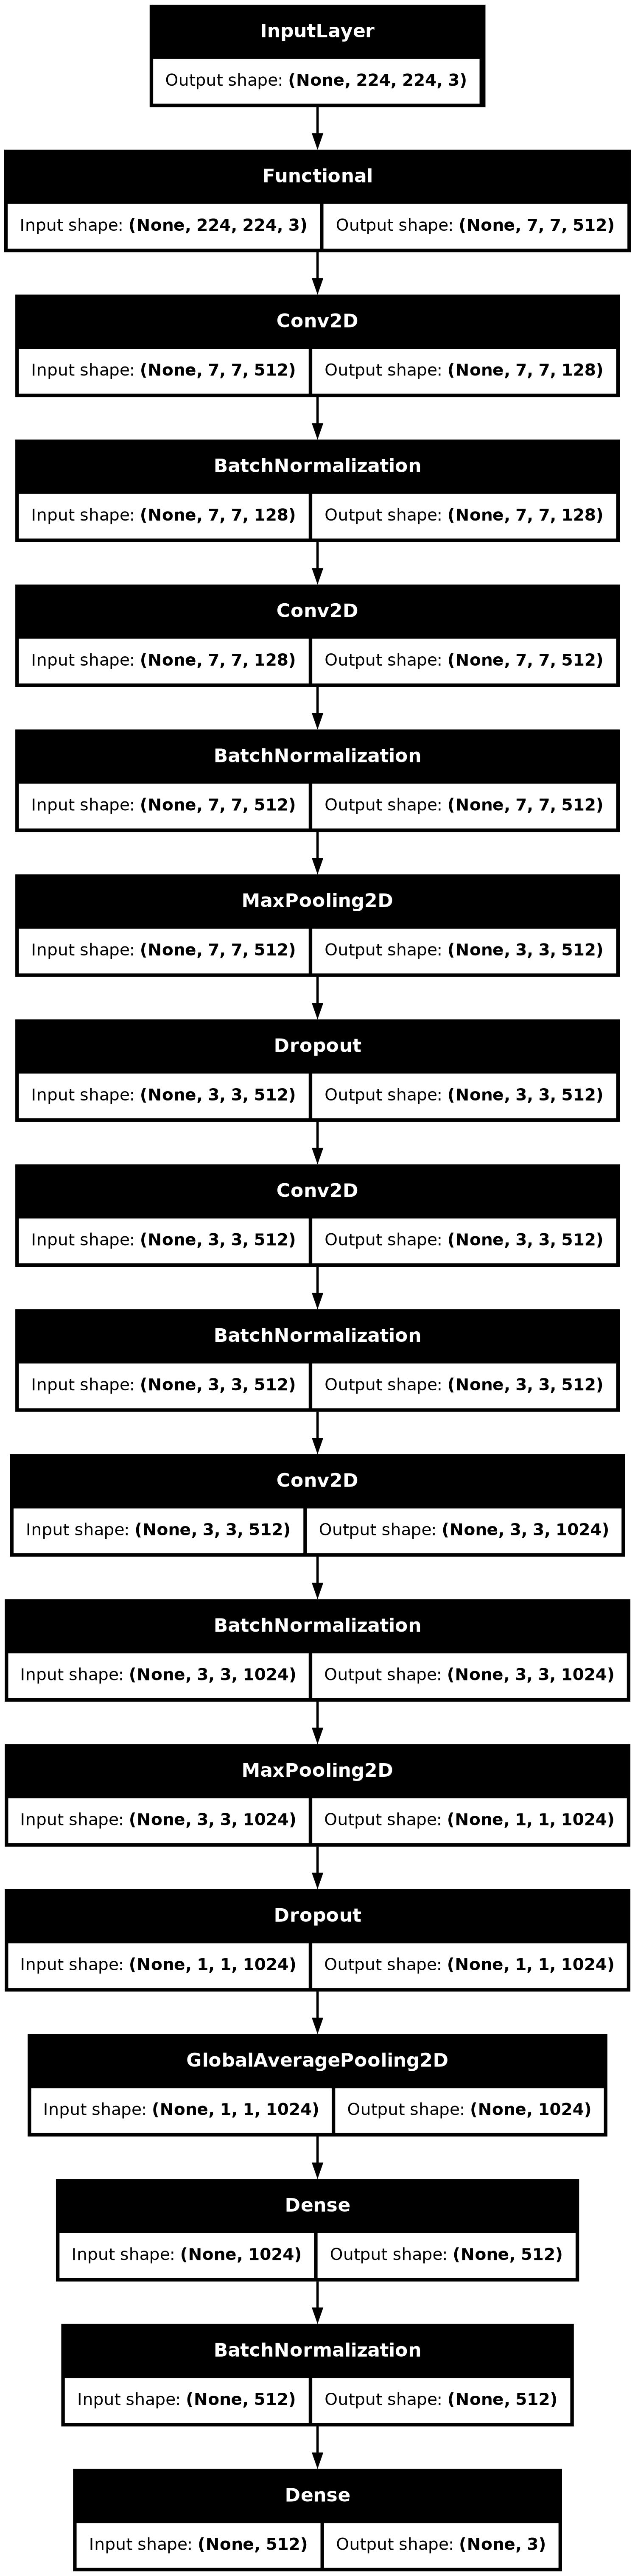

In [12]:
plot_model(model, show_shapes=True)

In [13]:
epochs = 60
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(patience=3, restore_best_weights=True)


history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=val_gen, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/60


2024-06-19 00:07:27.414909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_266/cond/StatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


388/388 ━━━━━━━━━━━━━━━━━━━━ 91s 169ms/step - accuracy: 0.6160 - loss: 0.9715 - val_accuracy: 0.6113 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 2/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step - accuracy: 0.7726 - loss: 0.4888 - val_accuracy: 0.3902 - val_loss: 3.7475 - learning_rate: 0.0010
Epoch 3/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 59s 152ms/step - accuracy: 0.7972 - loss: 0.4578 - val_accuracy: 0.7030 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 4/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - accuracy: 0.8065 - loss: 0.4316 - val_accuracy: 0.8511 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 5/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 59s 151ms/step - accuracy: 0.8314 - loss: 0.3741 - val_accuracy: 0.8248 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 6/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 59s 151ms/step - accuracy: 0.8400 - loss: 0.3635 - val_accuracy: 0.8398 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 7/60
388/388 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.8497 - loss:

## Model Evaluation

In [14]:
loss, accuracy = model.evaluate(test_gen)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9118 - loss: 0.1969
Loss: 0.18458296358585358
Accuracy: 0.9150375723838806


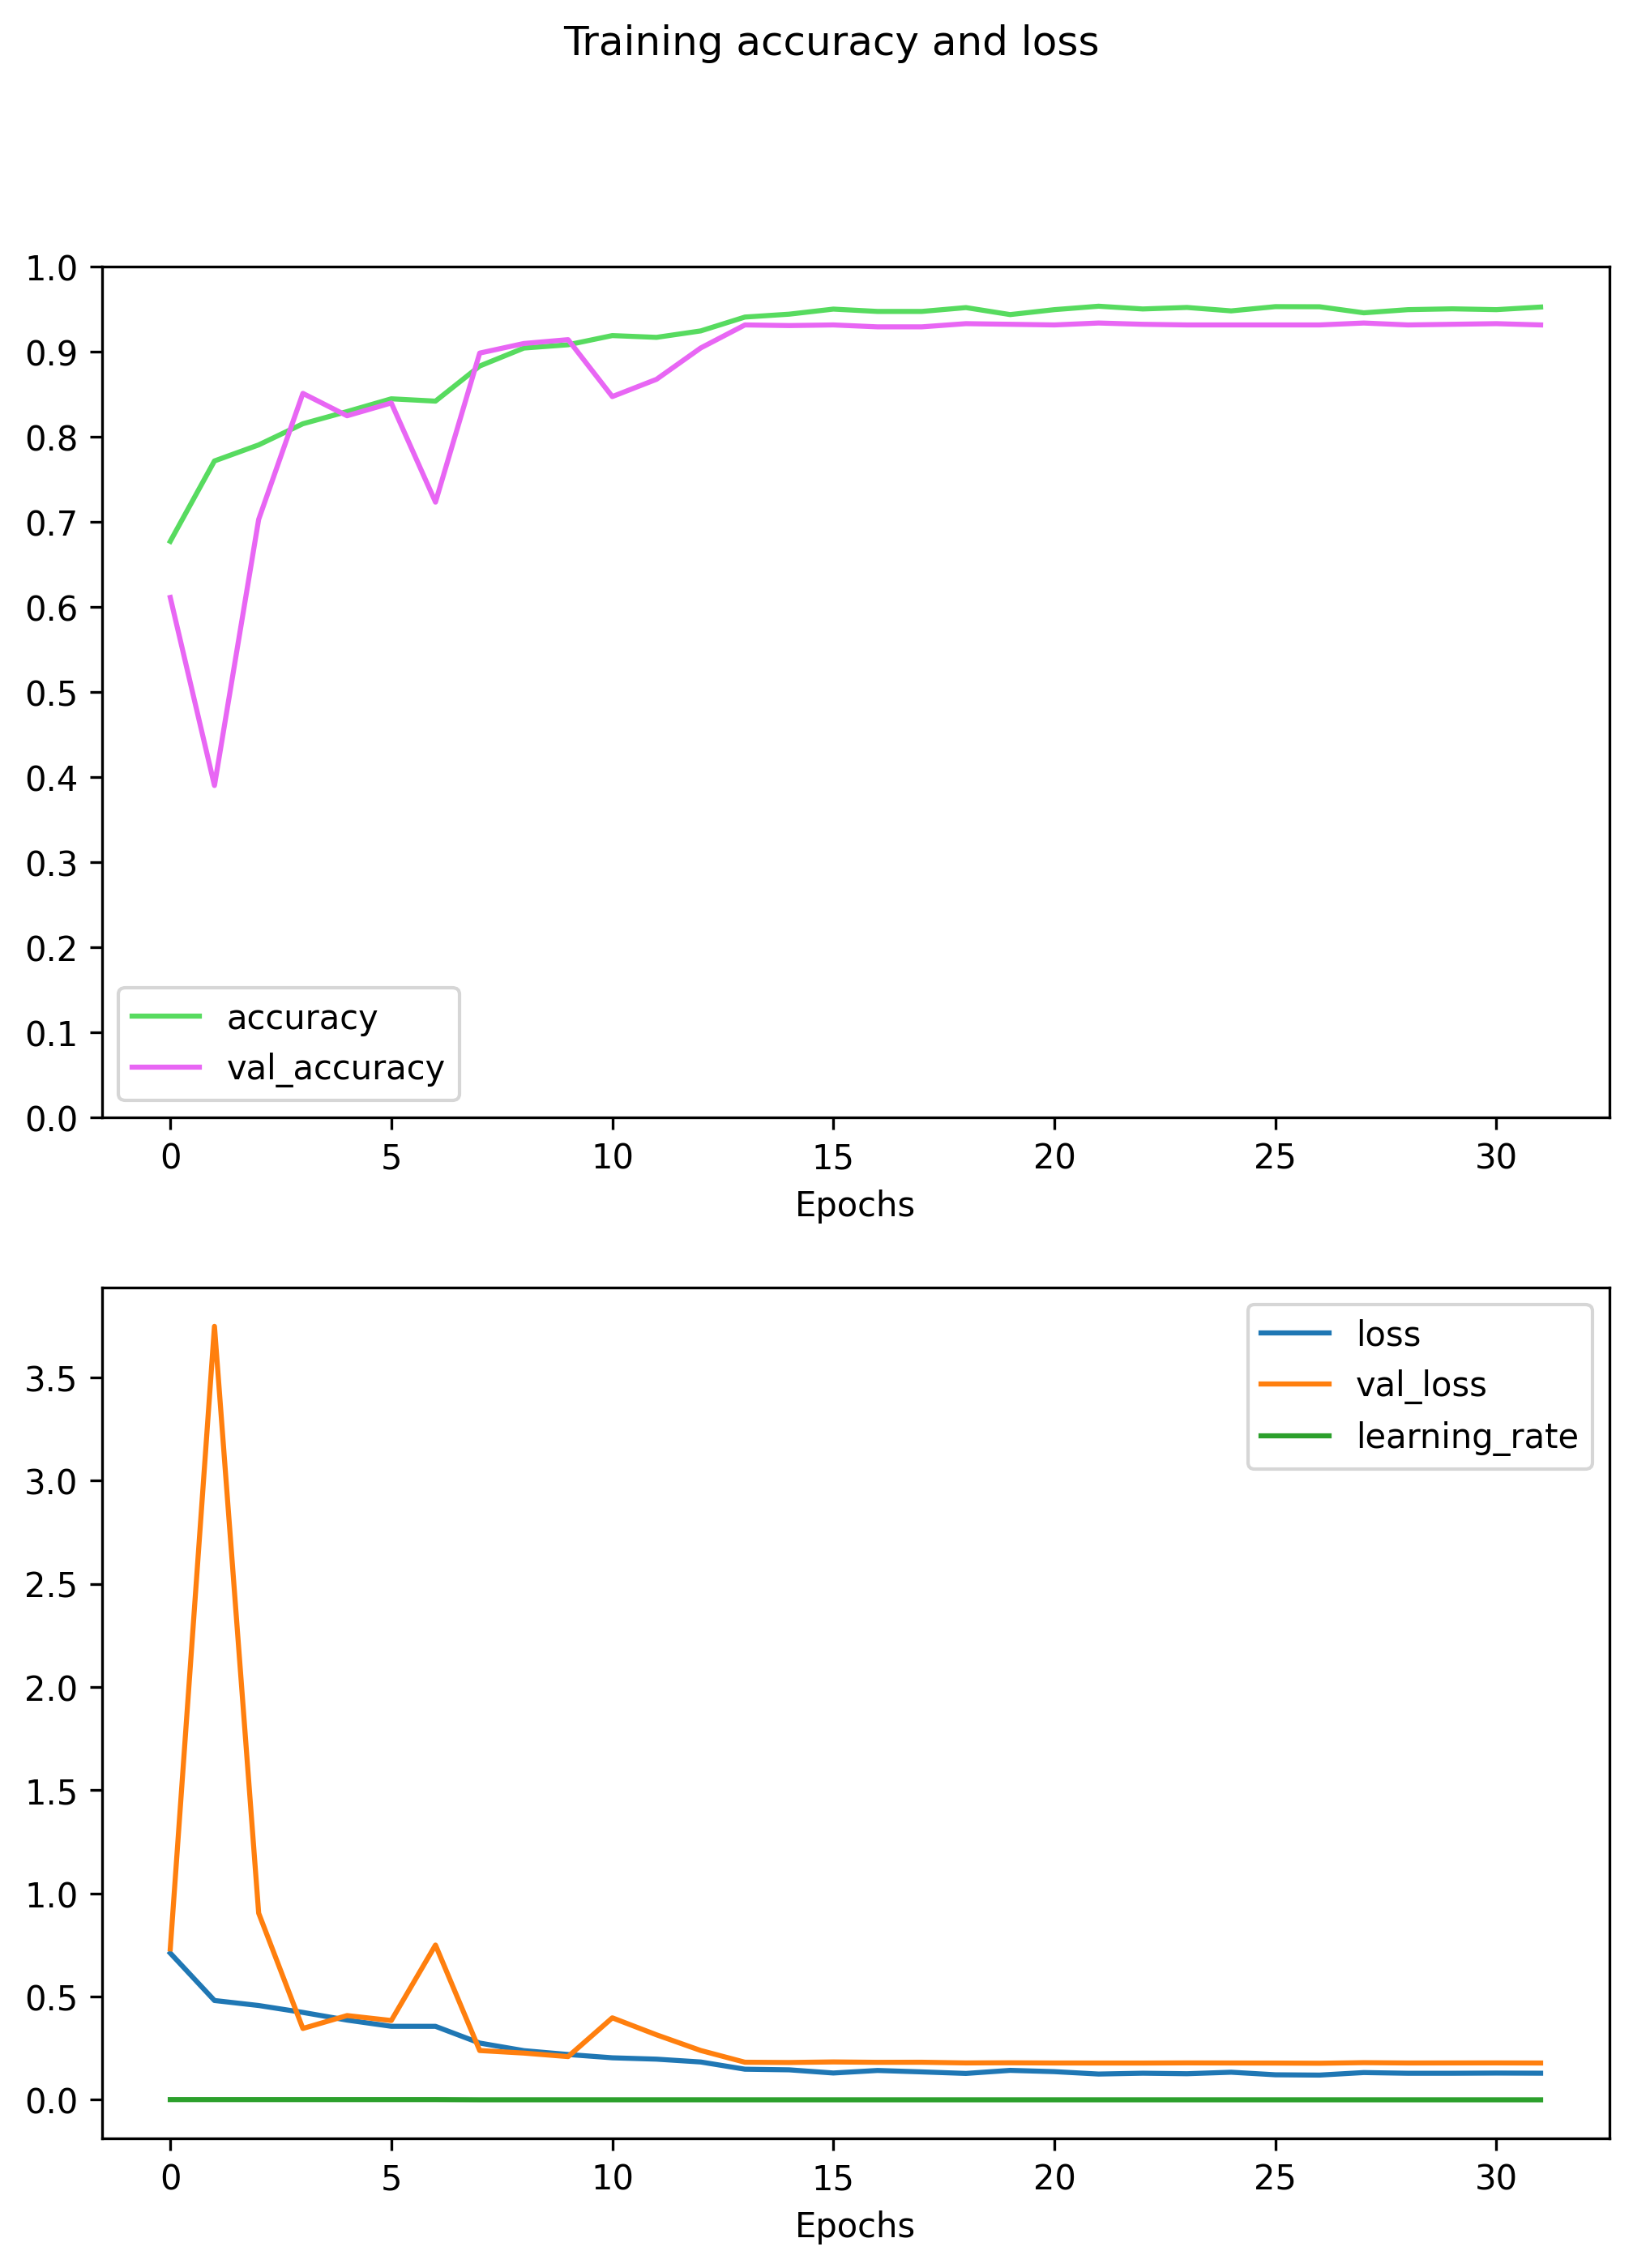

In [15]:
acc_loss_metrics = history.history

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)
plt.suptitle("Training accuracy and loss")
for lable, values in acc_loss_metrics.items():
    if lable == "accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("hls")[2])
    elif lable == "val_accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("husl")[5])
    else:
        ax[1].plot(values, label=lable)

ax[0].set_xlabel("Epochs")
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].legend()

ax[1].set_xlabel("Epochs")
ax[1].legend()
plt.show()

In [16]:
y_pred = model.predict(test_gen)

84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step


In [17]:
y_pred_labels =  np.argmax(y_pred, axis=1)
y_test = test_gen.classes

In [18]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       972
           1       0.86      0.85      0.86       765
           2       0.88      0.88      0.88       922

    accuracy                           0.92      2659
   macro avg       0.91      0.91      0.91      2659
weighted avg       0.92      0.92      0.92      2659



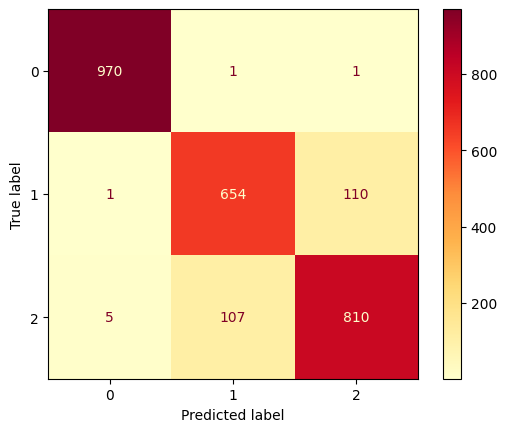

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels, cmap='YlOrRd')